In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import math
import shapely as shp
from datetime import datetime
from fiona.crs import from_epsg
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import re
from pandas.tseries.holiday import get_calendar, HolidayCalendarFactory, GoodFriday
from datetime import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from itertools import compress

np.random.seed(222)

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### perhaps add a feature that is the number of occupied properties within a buffer of every property

## Notes 2-1-17
1. add MCM condition to dummy variables ###CHECK
2. add any houses that score very high on the occupancy model as homes that should not be demolished ###CHECK
3. update DFD fire list
4. figure out regularization techniques for logit "regression" model ###check
5. run accuracy scores / 'mse' ###check

## Notes 2-13-17

1. add feature that is the number of vacant homes in the census block that a given house belongs to
2. alternative  - add feature that is the # of vacant homes in a given buffer from a property
3. start writing up documentation 


## Notes 2-15-17

1. apply model to full dataset ###CHECK
2. add continuous probabilities to model outputs
3. write up timesheet by next wednesday
4. final paper written by March 2nd?

## Notes 2-21-17
1. build SVM model? ###CHECK
2. I need lat / lon of parcels - Parcel2016.gdb! in the data folder!
3. finalize model, export to .csv

## Notes 2-22-17
1. tune hyperparameters of randomtree ###CHECK
2. finalize model, export to .csv ###CHECK


## notes 3-1-17
1. preserve Account_ID ###CHECK
2. program in classification threshold - do this by friday ###CHECK
3. build model w/out mcm data and see what happens

## Notes 3-16-17
1. add histogram with (1%) buckets showing counts of houses ###CHECK

In [2]:
wd = os.getcwd()
os.chdir('../data')
os.getcwd()

'/Users/geoffperrin/Desktop/DLBA/demo_project/data'

In [3]:
#read in detroit feature dataset
city_df = pd.read_csv('CitywideIndicators_20170221.csv')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## build labeled training dataset

In [4]:
#remove lots
dlba_df = city_df[city_df['Property Class'] != 'Residential-Lot']

#only keep residential lots
dlba_df = dlba_df[dlba_df['Property Class'] == 'Residential-Structure']


dlba_df_small = dlba_df.rename(columns=lambda x: x.replace(' ', '_'))
dlba_df_small.head()

,Account_ID,Parcel_ID,Account_Name,Property_Ownership,Property_Class,Program,Current_Status,Non-City_Demo_Program,Current_Status_Date,Neighborhood,...,MCM_Institutional_Use,MCM_Public_Use,MCM_Condition,MCM_Fire_Damage,MCM_Level_of_Fire_Damage,MCM_Boarding_Needed,MCM_Trespass,MCM_Vacant_Lot,MCM_Maintained,MCM_Dumping
1,001j000000Idvvm,22027073.,19759 Littlefield,Non-DLBA Owned,Residential-Structure,NaN,NaN,NaN,NaN,Greenwich,...,NaN,NaN,Good,NaN,NaN,No,NaN,NaN,NaN,No
2,001j000000Idxml,22054984.,15454 Prevost,Non-DLBA Owned,Residential-Structure,NaN,NaN,NaN,NaN,Crary/St Marys,...,NaN,NaN,Good,NaN,NaN,No,NaN,NaN,NaN,No
3,001j000000Idzep,21077398.,6150 University Pl,Non-DLBA Owned,Residential-Structure,NaN,NaN,NaN,NaN,Cornerstone Village,...,NaN,NaN,Good,No,NaN,No,NaN,NaN,NaN,No
4,001j000000Ie1Xa,22059049.,15805 St Marys,Non-DLBA Owned,Residential-Structure,NaN,NaN,NaN,NaN,Crary/St Marys,...,NaN,NaN,Good,NaN,NaN,Yes,NaN,NaN,NaN,No
5,001j000000Ie3Rg,22062755.,14740 Woodmont,Non-DLBA Owned,Residential-Structure,NaN,NaN,NaN,NaN,Grand River-St Marys,...,NaN,NaN,Good,NaN,NaN,No,NaN,NaN,NaN,No


## need to fix nans in neighborhood sales median
### all the neighborhoods should be in there, but some rows have NaNs!

In [5]:
dlba_df_neighborhood = dlba_df_small[['Neighborhood', 'Neighborhood_Sales_Median']]
dlba_df_neighborhood.groupby(['Neighborhood'], as_index=False).mean().head()

,Neighborhood,Neighborhood_Sales_Median
0,Airport Sub,0.57
1,Arden Park,NaN
2,Aviation Sub,6.24
3,Bagley,11.68
4,Barton-McFarland,1.24


In [6]:
#read in detroit parcel distance to school df
school_df = pd.read_csv('DistanceToSchool_20170123.csv')
school_df_small = school_df[["PARCELNO", "DistanceToSchool_FT"]]
school_df_small.columns = ['Parcel_ID', 'dist_to_school']
school_df_small.head()

,Parcel_ID,dist_to_school
0,16006256.,2196.731029
1,04000103-4,2375.448135
2,04003341.,2442.534185
3,04003339-40,2510.715691
4,04000119.,2341.253487


In [7]:
#merge distance to school to city feature df
dlba_school_df = dlba_df_small.merge(school_df_small, on='Parcel_ID')
len(dlba_school_df)

233839

In [8]:
#code dummy variables

#mcm condition dummies
dlba_school_df['mcm_good_dummy'] = 0
dlba_school_df['mcm_good_dummy'] = [1 if i=='Good' else 0 for i in dlba_school_df['MCM_Condition']]

dlba_school_df['mcm_fair_dummy'] = 0
dlba_school_df['mcm_fair_dummy'] = [1 if i=='Fair' else 0 for i in dlba_school_df['MCM_Condition']]

dlba_school_df['mcm_poor_dummy'] = 0
dlba_school_df['mcm_poor_dummy'] = [1 if (i=='Poor' or i=='poor, fair') else 0 for i in dlba_school_df['MCM_Condition']]

dlba_school_df['mcm_demo_dummy'] = 0
dlba_school_df['mcm_demo_dummy'] = [1 if (i=='Suggest Demolition' or i=='suggest demolition, poor') else 0 for i in dlba_school_df['MCM_Condition']]

dlba_school_df['mcm_good_dummy'] = 0
dlba_school_df['mcm_good_dummy'] = [1 if i=='Good' else 0 for i in dlba_school_df['MCM_Condition']]

dlba_school_df['dng_dummy'] = 0
dlba_school_df['dng_dummy'] = [0 if pd.isnull(i) else 1 for i in dlba_school_df['DNG_Number']]

dlba_school_df['fire_dummy'] = 0
dlba_school_df['fire_dummy'] = [0 if pd.isnull(i) else 1 for i in dlba_school_df['DFD_Fire:_Occurrence_Date']]

dlba_school_df['usps_vacant_dummy'] = 0
dlba_school_df['usps_vacant_dummy'] = [0 if pd.isnull(i) else 1 for i in dlba_school_df['USPS:_Vacancy_Indicated']]

dlba_school_df['foreclosed_dummy'] = 0
dlba_school_df['foreclosed_dummy'] = [0 if pd.isnull(i) else 1 for i in dlba_school_df['Foreclosure_Year']]

#change to current date
dlba_school_df['foreclosure_lag'] = 0
dlba_school_df['foreclosure_lag'] = [0 if pd.isnull(i) else (2017 - i) for i in dlba_school_df['Foreclosure_Year']]

dlba_school_df['boarding_needed_dummy'] = 0
dlba_school_df['boarding_needed_dummy'] = [0 if (pd.isnull(i) or i == 'No') else 1 for i in dlba_school_df['MCM_Boarding_Needed']]

dlba_school_df['dumping_dummy'] = 0
dlba_school_df['dumping_dummy'] = [0 if (pd.isnull(i) or i == 'No') else 1 for i in dlba_school_df['MCM_Dumping']]

#replace NaNs with zeros
dlba_school_df['Occupancy_Model:_Probability_Pct'] = [0 if pd.isnull(i) else i for i in dlba_school_df['Occupancy_Model:_Probability_Pct']]

#remove NaNs for Neighborhood_Sales_Median
#in final roll out I need to improve this!!!
dlba_school_df = dlba_school_df[~pd.isnull(dlba_school_df['Neighborhood_Sales_Median'])]




In [9]:
# create a full copy of the data in order to apply model to it at the end
dlba_school_df_full = dlba_school_df.copy()

dlba_school_df_full_small = dlba_school_df_full.drop(['Property_Ownership', 'Property_Class', 'Program', \
                                            'Current_Status', 'Current_Status_Date', 'Neighborhood', 'DNG_Number', \
                                            'WCT_Foreclosure_Status', \
                                            'MCM_Blext_Created_At', 'MCM_Structure', 'MCM_Occupancy',  'MCM_Use',\
                                           'MCM_Units', 'MCM_Residence_Type', 'MCM_Commercial_Use', 'MCM_Industrial_Use',\
                                           'MCM_Institutional_Use', 'MCM_Public_Use', 'MCM_Level_of_Fire_Damage', \
                                            'MCM_Trespass', 'MCM_Vacant_Lot', 'MCM_Maintained', 'DFD_Fire:_Occurrence_Date',\
                                           'USPS:_Vacancy_Indicated', 'Foreclosure_Year', 'MCM_Fire_Damage',\
                                           'USPS:_Last_Update', 'Occupancy_Model:_Last_Update', 'MCM_Boarding_Needed',\
                                           'MCM_Dumping', 'MCM_Condition'], 1)

dlba_school_df_full_small = dlba_school_df_full_small.rename(columns={'Occupancy_Model:_Probability_Pct': 'occupancy_model_pct'})
dlba_school_df_full_small = dlba_school_df_full_small[['Account_ID', 'Parcel_ID', 'Account_Name', 'Neighborhood_Sales_Median',\
                                            'occupancy_model_pct', 'dist_to_school',\
                                            'fire_dummy', 'usps_vacant_dummy', 'foreclosed_dummy',\
                                            'foreclosure_lag', 'boarding_needed_dummy', 'dumping_dummy', 'dng_dummy',]]


In [10]:
#need to only apply demo decision to above occupancy threshold & dlba owned properties
#only keep DLBA Owned properties for the training data OR with a very high occupancy score

no_demo_occupancy_thresh = 95.0
dlba_school_df = dlba_school_df[(dlba_school_df['Property_Ownership'] == 'DLBA Owned') | \
                  (dlba_school_df['Occupancy_Model:_Probability_Pct'] > no_demo_occupancy_thresh)]

#code up demo decision yes / no
demo_decision_dict = {'Demo Awaiting Funding': 1,
        'Demo Pipeline': 1,
        'Demo Contracted': 1,
        'Demo Review': 1,
        'Demolished': 999,
        'Construction Complete': 0,
        'Occupied': 0,
        'Sold': 0,
        'Institutional Partner Coordination': 999,
        'For Sale': 0,
        'Sales Review': 0,
        'Sales Pipeline': 0,
        'Vacant Land': 999,
        'Sales Hold': 0,
        'Under Construction': 999,
        'Lease/ROE/TLA': 999,
        'Warehouse': 999,
        'NPOC Isolation - Do not move!': 999,
        'NSP Quarantine': 999,
        'Reconveyance Complete': 999,
        'Title Problem Identified': 999,
        'DJ Quarantine': 999,
        'PDD Quarantine': 999,
        'Intake Review': 999}

#if occupancy score > threshold, then no demo
dlba_school_df['Current_Status']\
[dlba_school_df['Occupancy_Model:_Probability_Pct'] > no_demo_occupancy_thresh] = 'Occupied'

#if MLB demo, then yes demo
dlba_school_df['Current_Status']\
[dlba_school_df['Non-City_Demo_Program'] =='MLB Demo'] = 'Demo Pipeline'

dlba_school_df['demo_decision'] = 0
dlba_school_df['demo_decision'] = [demo_decision_dict[i] for i in dlba_school_df["Current_Status"]]



dlba_school_df = dlba_school_df[dlba_school_df['demo_decision'] != 999]

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
# only keep DLBA Owned properties for the training data OR with a very high occupancy score: we only want
# labelled data in the training dataset

dlba_school_df = dlba_school_df[(dlba_school_df['Property_Ownership'] == 'DLBA Owned') | \
                  (dlba_school_df['Occupancy_Model:_Probability_Pct'] > no_demo_occupancy_thresh)]

dlba_school_df_small = dlba_school_df.drop(['Account_ID', 'Property_Ownership', 'Property_Class', 'Program', \
                                            'Current_Status', 'Current_Status_Date', 'Neighborhood', 'DNG_Number', \
                                            'WCT_Foreclosure_Status', \
                                            'MCM_Blext_Created_At', 'MCM_Structure', 'MCM_Occupancy',  'MCM_Use',\
                                           'MCM_Units', 'MCM_Residence_Type', 'MCM_Commercial_Use', 'MCM_Industrial_Use',\
                                           'MCM_Institutional_Use', 'MCM_Public_Use', 'MCM_Level_of_Fire_Damage', \
                                            'MCM_Trespass', 'MCM_Vacant_Lot', 'MCM_Maintained', 'DFD_Fire:_Occurrence_Date',\
                                           'USPS:_Vacancy_Indicated', 'Foreclosure_Year', 'MCM_Fire_Damage',\
                                           'USPS:_Last_Update', 'Occupancy_Model:_Last_Update', 'MCM_Boarding_Needed',\
                                           'MCM_Dumping', 'MCM_Condition'], 1)

dlba_school_df_small = dlba_school_df_small.rename(columns={'Occupancy_Model:_Probability_Pct': 'occupancy_model_pct'})
dlba_school_df_small = dlba_school_df_small[['Parcel_ID', 'Account_Name', 'demo_decision', 'Neighborhood_Sales_Median',\
                                            'occupancy_model_pct', 'dist_to_school',\
                                            'fire_dummy', 'usps_vacant_dummy', 'foreclosed_dummy',\
                                            'foreclosure_lag', 'boarding_needed_dummy', 'dumping_dummy', 'dng_dummy']]


## Build Logit Classification Model

In [12]:
y = dlba_school_df_small.demo_decision
X = dlba_school_df_small.iloc[:,3:]
'''
let's try this without the crossvalidation loop first


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i)
    
    #learn logistic regression over the training sample
    logit = LogisticRegression(C=1)
    logit.fit(X_train, y_train)
    # C here controls the regularization strength--which will be discussed in Bayesian session
    # For now just keep in mind that setting a high value will make the regularization ineffective

    #apply to the validation sample
    labelPred = logit.predict(X_test)
    #labelPred = logPred > 0.5
    labelActual = y_test
    
'''    


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
    
#learn logistic regression over the training sample
logit = LogisticRegression(C=1)
logit.fit(X_train, y_train)
# C here controls the regularization strength--which will be discussed in Bayesian session
# For now just keep in mind that setting a high value will make the regularization ineffective

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### logit model - Accuracy

In [13]:
#apply to the validation sample
labelPred = logit.predict(X_test)
labelActual = y_test
X_test_copy = X_test.copy()
X_test_copy['logit_predict'] = logit.predict(X_test)

In [14]:
#compute TP,FP,FN,TN for the above classification
TP = sum((labelPred==1)&(labelActual==1))
FP = sum((labelPred==1)&(labelActual==0))
FN = sum((labelPred==0)&(labelActual==1))
TN = sum((labelPred==0)&(labelActual==0))

#compute precision, accuracy and recall
Acc = 100.0 * (TP+TN)/(TP+TN+FP+FN)
Rec = 100.0 * TP/(TP+FN)
Prec= 100.0 * TP/(TP+FP)
print('Precision = %.2f%%\nAccuracy = %.2f%%\nRecall = %.2f%%'%(Prec,Acc,Rec))

Precision = 74.77%
Accuracy = 96.03%
Recall = 74.90%


#### look at auc

In [15]:
res=[]
for i in range(1,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i)
    pred=logit.predict_proba(X_test)[:,1]
    res.append(rs(np.array(y_test.apply(int)),pred))
    #print rs(np.array(y_test.apply(int)),pred)
print np.mean(res)

0.9843027978


## Build Random Forest Classification Model

In [16]:
r_tree = RFC()
param_grid = {'max_depth': [3, 5, 7, 9], 'n_estimators': np.arange(1,502,100)}
r_tree_tuned = GridSearchCV(r_tree, param_grid)
#r_tree_optimum = RFC(r_tree_tuned.best_estimator_)
r_tree_tuned.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1, 101, 201, 301, 401, 501]), 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
feature_importance = r_tree_tuned.best_estimator_.fit(X_train, y_train).feature_importances_

In [18]:
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False)

,variables,importance
1,occupancy_model_pct,0.38982
9,dng_dummy,0.22631
7,boarding_needed_dummy,0.158358
8,dumping_dummy,0.0693644
6,foreclosure_lag,0.067962
0,Neighborhood_Sales_Median,0.0314996
5,foreclosed_dummy,0.0287518
2,dist_to_school,0.0183772
3,fire_dummy,0.00524284
4,usps_vacant_dummy,0.00431445


### random forest model - Accuracy

In [19]:
#apply to the validation sample
labelPred = r_tree_tuned.predict(X_test)
labelPred_cont = r_tree_tuned.predict_proba(X_test)[:,1]
labelActual = y_test
X_test_copy['r_tree_predict'] = r_tree_tuned.predict(X_test)
X_test_copy['labelActual'] = y_test
sum(labelPred)

3607

#### look at precision / accuracy / recall

In [20]:
#compute TP,FP,FN,TN for the above classification
TP = sum((labelPred==1)&(labelActual==1))
FP = sum((labelPred==1)&(labelActual==0))
FN = sum((labelPred==0)&(labelActual==1))
TN = sum((labelPred==0)&(labelActual==0))

#compute precision, accuracy and recall
Prec= 100.0 * TP/(TP+FP)
Acc = 100.0 * (TP+TN)/(TP+TN+FP+FN)
Rec = 100.0 * TP/(TP+FN)
print('Precision = %.2f%%\nAccuracy = %.2f%%\nRecall = %.2f%%'%(Prec,Acc,Rec))

Precision = 76.16%
Accuracy = 96.06%
Recall = 76.43%


#### look at auc

In [21]:
res=[]
for i in range(1,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i)
    pred=r_tree_tuned.predict_proba(X_test)[:,1]
    res.append(rs(np.array(y_test.apply(int)),pred))
print np.mean(res)

0.98792490998


### Determine optimal threshold for maximizing true positives and minimizing false negatives

In [22]:
#do a 20 fold split and take average cutoff point of all splits
cutoff_list = []
for i in range(1,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i)
    pred=r_tree_tuned.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    threshold_df = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
    threshold_df['tpr_plus_one_minus_fpr'] = threshold_df.tpr + 100*(1-threshold_df.fpr)
    threshold_df = threshold_df.sort(['tpr_plus_one_minus_fpr'], ascending=False)
    threshold_df = threshold_df.reset_index()
    cutoff_list.append(threshold_df.thresholds[0])

avg_cutoff = np.mean(cutoff_list)
print avg_cutoff

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


0.846999540075


In [23]:
### sample tpr / fpr rate for a given test / train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i)
pred=r_tree_tuned.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
threshold_df = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
threshold_df['value_to_maximize'] = threshold_df.tpr + 10*(1-threshold_df.fpr)
threshold_df = threshold_df.sort(['value_to_maximize'], ascending=False)
roc_auc = rs(np.array(y_test.apply(int)),pred)
#threshold_df = threshold_df.reset_index()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


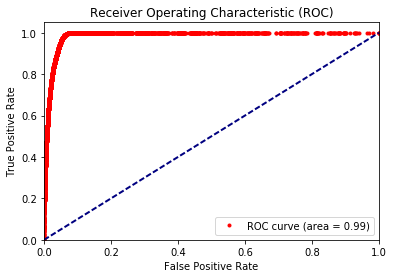

In [24]:
#Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(threshold_df['fpr'], threshold_df['tpr'], 'r.',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [25]:
labelPred_w_threshold = labelPred_cont.copy()
labelPred_w_threshold[labelPred_w_threshold >= avg_cutoff] = 1
labelPred_w_threshold[labelPred_w_threshold < avg_cutoff] = 0

In [26]:
#compute TP,FP,FN,TN for the above classification
TP = sum((labelPred_w_threshold==1)&(labelActual==1))
FP = sum((labelPred_w_threshold==1)&(labelActual==0))
FN = sum((labelPred_w_threshold==0)&(labelActual==1))
TN = sum((labelPred_w_threshold==0)&(labelActual==0))

#compute precision, accuracy and recall
Prec= 100.0 * TP/(TP+FP)
Acc = 100.0 * (TP+TN)/(TP+TN+FP+FN)
Rec = 100.0 * TP/(TP+FN)
print('Precision = %.2f%%\nAccuracy = %.2f%%\nRecall = %.2f%%'%(Prec,Acc,Rec))

Precision = 92.68%
Accuracy = 93.61%
Recall = 25.01%


In [27]:
print TP, FP, FN, TN

899 71 2695 39623


## SVM Model 
### - not implimenting this, takes way too long to fit, takes many, MANY hours to actually tune hyperparameters

In [28]:
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5]}
#svr = svm.SVC()
#clf = GridSearchCV(svr, parameters)
#svr_optimum = svr.fit(X_train, y_train)

In [29]:
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 500, 1000, 10000]}
#svr = svm.SVC()
#clf = GridSearchCV(svr, parameters)
#svr_optimum = clf.fit(X_train, y_train)

### SVM - Accuracy

In [30]:
#apply to the validation sample
#labelPred = svr_optimum.predict(X_test)
#labelActual = y_test
#X_test_copy['SVM_predict'] = svr_optimum.predict(X_test)

#### look at precision / accuracy / recall

In [31]:
'''
#compute TP,FP,FN,TN for the above classification
TP = sum((labelPred==1)&(labelActual==1))
FP = sum((labelPred==1)&(labelActual==0))
FN = sum((labelPred==0)&(labelActual==1))
TN = sum((labelPred==0)&(labelActual==0))

#compute precision, accuracy and recall
Prec= 100.0 * TP/(TP+FP)
Acc = 100.0 * (TP+TN)/(TP+TN+FP+FN)
Rec = 100.0 * TP/(TP+FN)
print('Precision = %.2f%%\nAccuracy = %.2f%%\nRecall = %.2f%%'%(Prec,Acc,Rec))
'''

"\n#compute TP,FP,FN,TN for the above classification\nTP = sum((labelPred==1)&(labelActual==1))\nFP = sum((labelPred==1)&(labelActual==0))\nFN = sum((labelPred==0)&(labelActual==1))\nTN = sum((labelPred==0)&(labelActual==0))\n\n#compute precision, accuracy and recall\nPrec= 100.0 * TP/(TP+FP)\nAcc = 100.0 * (TP+TN)/(TP+TN+FP+FN)\nRec = 100.0 * TP/(TP+FN)\nprint('Precision = %.2f%%\nAccuracy = %.2f%%\nRecall = %.2f%%'%(Prec,Acc,Rec))\n"

#### look at auc

In [32]:
'''
res=[]
for i in range(1,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i)
    pred=svr_optimum.predict(X_test)
    res.append(rs(np.array(y_test.apply(int)),pred))
    #print rs(np.array(y_test.apply(int)),pred)
print np.mean(res)
'''

'\nres=[]\nfor i in range(1,20):\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i)\n    pred=svr_optimum.predict(X_test)\n    res.append(rs(np.array(y_test.apply(int)),pred))\n    #print rs(np.array(y_test.apply(int)),pred)\nprint np.mean(res)\n'

## Apply models to full dataset

In [33]:
# apply to full dataset
dlba_school_df_full_small_copy = dlba_school_df_full_small.copy()
dlba_school_df_full_small_X = dlba_school_df_full_small_copy.iloc[:,3:]
dlba_school_df_full_small['r_tree_predict'] = r_tree_tuned.predict(dlba_school_df_full_small_X)
dlba_school_df_full_small['r_tree_predict_continuous'] = r_tree_tuned.predict_proba(dlba_school_df_full_small_X)[:,1]

In [34]:
dlba_school_df_full_small.head(20)

,Account_ID,Parcel_ID,Account_Name,Neighborhood_Sales_Median,occupancy_model_pct,dist_to_school,fire_dummy,usps_vacant_dummy,foreclosed_dummy,foreclosure_lag,boarding_needed_dummy,dumping_dummy,dng_dummy,r_tree_predict,r_tree_predict_continuous
0,001j000000Idvvm,22027073.,19759 Littlefield,4.16,99.66,1390.037738,0,1,0,0.0,0,0,0,0,0.000055
1,001j000000Idxml,22054984.,15454 Prevost,8.49,99.65,2291.720306,0,1,0,0.0,0,0,0,0,0.000049
2,001j000000Idzep,21077398.,6150 University Pl,7.03,93.91,1768.061975,0,1,0,0.0,0,0,0,0,0.011442
3,001j000000Ie1Xa,22059049.,15805 St Marys,8.49,93.91,3134.281189,0,1,0,0.0,1,0,0,0,0.010849
4,001j000000Ie3Rg,22062755.,14740 Woodmont,8.12,91.96,720.749462,0,1,0,0.0,0,0,0,0,0.043479
5,001j000000Ie5Ko,16027453.,16128 Turner,3.00,100.00,979.713445,0,1,0,0.0,0,0,0,0,0.000078
6,001j000000Ie7Ej,12006273.,16645 Lawton,1.42,99.48,852.641974,0,1,0,0.0,0,0,0,0,0.000227
7,001j000000Ie9HB,08010489.,15325 La Salle Blvd,0.64,14.09,941.297531,0,1,0,0.0,0,0,0,0,0.307848
8,001j000000IeBUo,10006510.,1483 16th St,9.11,100.00,2290.365887,0,1,0,0.0,0,0,0,0,0.000036
9,001j000000IeDP6,14011756.,4702 30th St,1.61,98.02,1751.155876,0,1,0,0.0,0,0,0,0,0.000179


In [35]:
### find addresses of interest
#dlba_school_df_full_small[dlba_school_df_full_small.Account_Name.str.contains("Parkland")]

## Export final dataset as csv

In [36]:
dlba_school_df_full_small.to_csv("/Users/geoffperrin/Desktop/DLBA/demo_project/output/final_demo_prediction_no_MCM_032217.csv")

In [54]:
dlba_school_df_full_small.head()

,Account_ID,Parcel_ID,Account_Name,Neighborhood_Sales_Median,occupancy_model_pct,dist_to_school,fire_dummy,usps_vacant_dummy,foreclosed_dummy,foreclosure_lag,boarding_needed_dummy,dumping_dummy,dng_dummy,r_tree_predict,r_tree_predict_continuous
0,001j000000Idvvm,22027073.,19759 Littlefield,4.16,99.66,1390.037738,0,1,0,0.0,0,0,0,0,0.000055
1,001j000000Idxml,22054984.,15454 Prevost,8.49,99.65,2291.720306,0,1,0,0.0,0,0,0,0,0.000049
2,001j000000Idzep,21077398.,6150 University Pl,7.03,93.91,1768.061975,0,1,0,0.0,0,0,0,0,0.011442
3,001j000000Ie1Xa,22059049.,15805 St Marys,8.49,93.91,3134.281189,0,1,0,0.0,1,0,0,0,0.010849
4,001j000000Ie3Rg,22062755.,14740 Woodmont,8.12,91.96,720.749462,0,1,0,0.0,0,0,0,0,0.043479


## Visuals

In [73]:
sort_predict = list(dlba_school_df_full_small.r_tree_predict_continuous)
sort_predict = sorted(sort_predict)

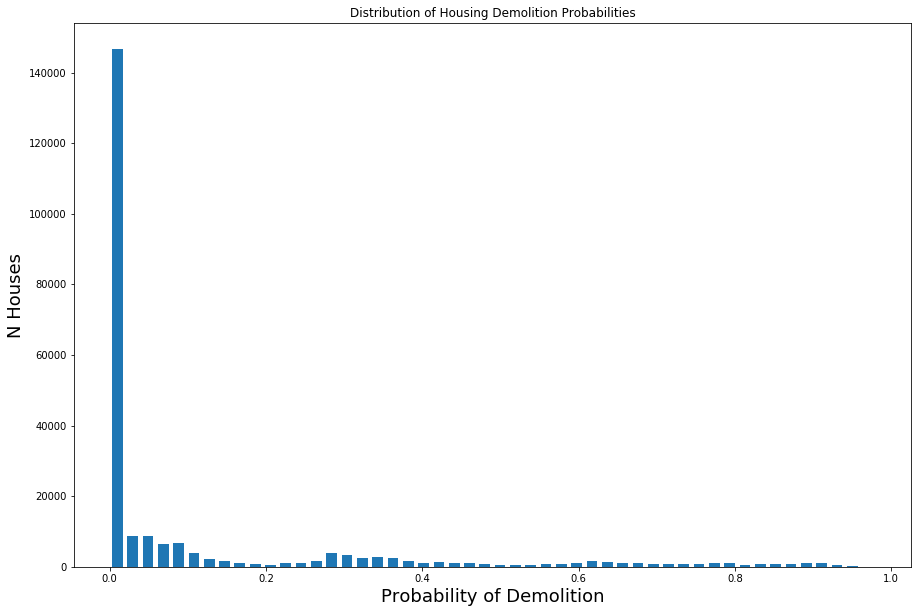

In [74]:
hist, bins = np.histogram(sort_predict, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(15,10))
plt.bar(center, hist, align='center', width=width)
plt.xlabel('Probability of Demolition', fontsize = 18)
plt.ylabel('N Houses', fontsize = 18)
plt.title("Distribution of Housing Demolition Probabilities")
plt.show()

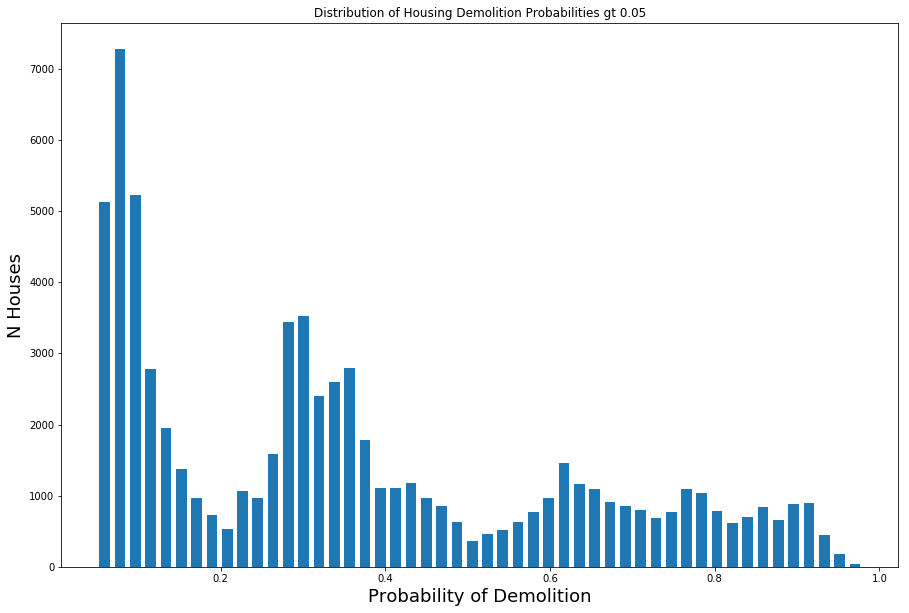

In [79]:
sort_predict_gt_zero = [num for num in sort_predict if num > 0.05]
hist, bins = np.histogram(sort_predict_gt_zero, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(15,10))
plt.bar(center, hist, align='center', width=width)
plt.xlabel('Probability of Demolition', fontsize = 18)
plt.ylabel('N Houses', fontsize = 18)
plt.title("Distribution of Housing Demolition Probabilities gt 0.05")
plt.show()